# Детектирование аномалий с помощью sklearn

In [1]:
import numpy as np
import scipy.stats as sps
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [2]:
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM

### EllipticEnvelope

<a href="https://scikit-learn.org/0.20/modules/generated/sklearn.covariance.EllipticEnvelope.html">Страница на sklearn</a>

Создадим данные: облако из нормального распределения и некоторые выбросы.

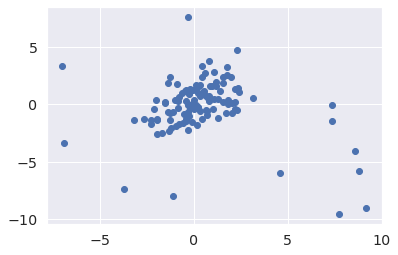

In [3]:
X = sps.multivariate_normal(cov=[[2, 1], [1, 2]]).rvs(size=100)
X = np.vstack([X, sps.uniform(loc=-10, scale=20).rvs(size=(15, 2))])
plt.scatter(X[:, 0], X[:, 1]);

Данный метод пытается построить эллиптическую оболочку типичных точек, отделив их от выбросов. Параметр `contamination` отвечает за ожидаемую долю выбросов.

In [4]:
model = EllipticEnvelope(contamination=0.15)
model.fit(X)

EllipticEnvelope(assume_centered=False, contamination=0.15, random_state=None,
                 store_precision=True, support_fraction=None)

Центр эллипса

In [5]:
model.location_

array([0.12671486, 0.28823447])

Матрица ковариаций (соответствует нормальному распределению)

In [6]:
model.covariance_

array([[1.53567586, 0.84108733],
       [0.84108733, 2.12482298]])

Степерью типичности точки служит метод `decision_function`, который вычисляет сдвинутое расстояние Махаланобиса. Сдвиг определяется так, чтобы отрицательные значения соответствовали выбросам.

In [7]:
model.decision_function([[0, 0],
                         [10, 0]])

array([  5.35688367, -77.57668225])

Визуализация полученного эллипса. Сам эллипс соответствует уравнению `model.decision_function(x)=0`.

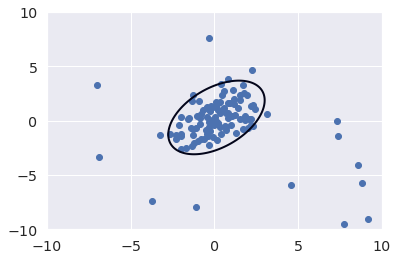

In [8]:
# двумерная сетка
X_grid, Y_grid = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 10, 500))
Z = model.decision_function(np.c_[X_grid.ravel(), Y_grid.ravel()])
Z = Z.reshape(X_grid.shape)

plt.contour(X_grid, Y_grid, Z, levels=[0], linewidths=2)
plt.scatter(X[:, 0], X[:, 1])

### Создание данных для других методов

Создадим данные с двумя нормальным кластерами, один из них плотный, другой -- разреженный. Дополительно добавим выбросы.

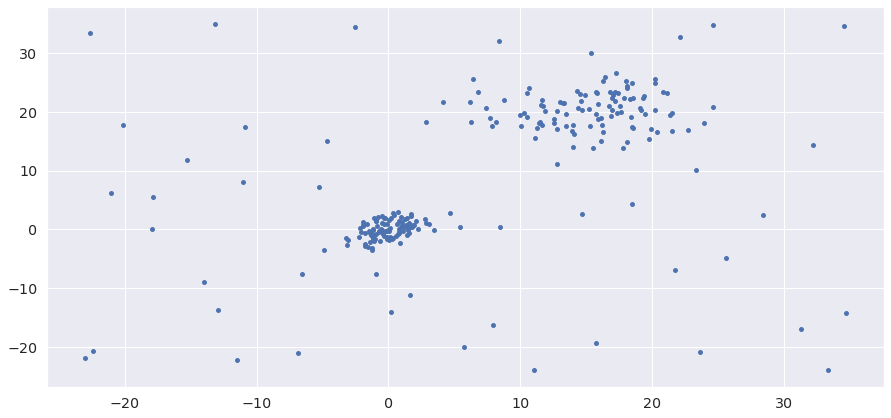

In [9]:
X1 = sps.multivariate_normal(cov=[[2, 1], [1, 2]]).rvs(size=100)
X2 = sps.multivariate_normal(mean=[15, 20], cov=[[15, 2], [2, 10]]).rvs(size=100)
X = np.vstack([X1, X2, sps.uniform(loc=-25, scale=60).rvs(size=(50, 2))])

plt.figure(figsize=(15, 7))
plt.scatter(X[:, 0], X[:, 1], s=15);

### IsolationForest

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html">Страница на sklearn</a>

Параметры:
* `n_estimators` -- число деревьев;
* `max_samples` -- размер выброки на каждое дерево;
* `max_features` -- количество признаков на каждое дерево;
* `contamination` -- ожидаемая доля выбросов;
* `bootstrap` -- использовать ли бутстрепные выборки;
* `n_jobs` -- количество процессов при распараллеливании.

Обучим лес на 200 деревьев

In [10]:
iforest = IsolationForest(contamination=0.15, n_estimators=200)
iforest.fit(X)

IsolationForest(behaviour='old', bootstrap=False, contamination=0.15,
                max_features=1.0, max_samples='auto', n_estimators=200,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

Степерью типичности точки служит метод `decision_function`, который вычисляет со сдвигом среднюю глубину листа, в который попадает точка. Сдвиг определяется так, чтобы отрицательные значения соответствовали выбросам.

In [11]:
iforest.decision_function([[0,0],
                           [10, 10],
                           [-20, -20]])

array([ 0.13847971, -0.02085678, -0.16622822])

Визуализация результата. Для построения графика создается двумерная сетка точек. Далее для каждой точки из сетки вычисляется значение решающей функции. Раскраска области создается при помощи функции `plt.contourf`.

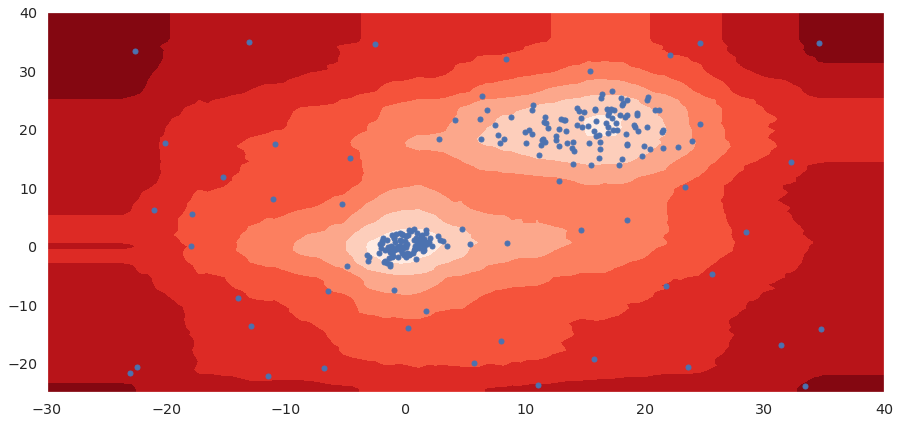

In [12]:
xx, yy = np.meshgrid(np.linspace(-30, 40, 100), np.linspace(-25, 40, 100))
Z = iforest.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15, 7))
plt.contourf(xx, yy, Z, cmap=plt.cm.Reds_r)
plt.scatter(X[:, 0], X[:, 1], s=25);

### LocalOutlierFactor

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html">Страница на sklearn</a>

Параметры:
* `n_neighbors` -- количество соседей;
* `metric` -- метрика;
* `p` -- параметр метрики Минковского;
* `contamination` -- ожидаемая доля выбросов;
* `novelty` -- использовать ли метод для обнаружения новизы или же для выбросов (по умолчанию);
* `n_jobs` -- количество процессов при распараллеливании.

Обучим модель, которая сразу выдаст метки (1 = типичная точка, -1 = выброс).

In [13]:
lof = LocalOutlierFactor(contamination=0.1, n_neighbors=10)
preds = lof.fit_predict(X)

In [14]:
preds

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        1,  1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1, -1,
        1,  1,  1, -1,  1

Отрицательная доля выбросов. Соответствует локальной доле выбросов (LOF), сдвинутой так, чтобы отрицательные значения соответствовали выбросам.

In [15]:
X_scores = lof.negative_outlier_factor_
X_scores[:5]

array([-1.0279096 , -1.48928875, -1.25569929, -0.9775965 , -1.32442236])

Визуализируем так, чтобы радиус круга точки соответствовал степени нетипичности точки. Чем меньше радиус, тем более типичной считается точка.

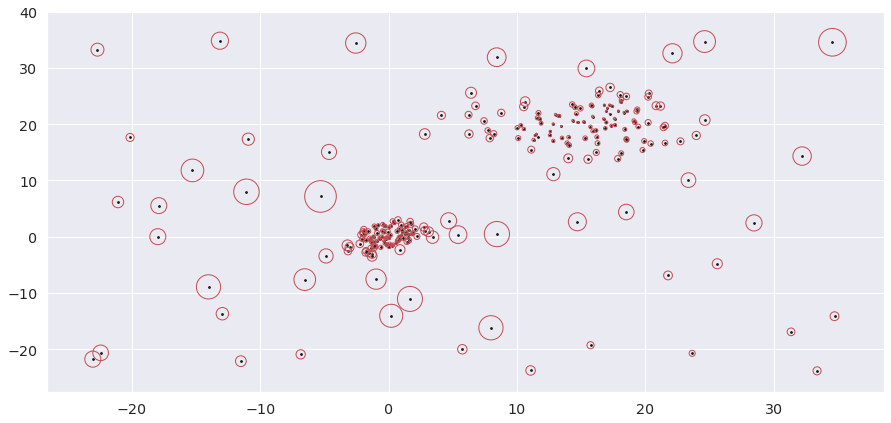

In [16]:
plt.figure(figsize=(15, 7))
plt.scatter(X[:, 0], X[:, 1], color='k', s=3)
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r', facecolors='none', lw=1);

### DBSCAN

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">Страница на sklearn</a>

Параметры:
* `eps` -- максимальное расстояние между двумя точками, при котором они считаются соседями;
* `min_samples` -- минимальное количесто соседей точки, при котором точка считается основной;
* `metric` -- метрика;
* `p` -- параметр метрики Минковского;
* `n_jobs` -- количество процессов при распараллеливании.

Обучаем модель, которая сразу выдаст метки (-1 = выброс, остальные метки соответствую номеру кластера).

In [17]:
db = DBSCAN(eps=2, min_samples=10)
preds = db.fit_predict(X)

Различные метки

In [18]:
np.unique(preds)

array([-1,  0,  1])

Визуализация результата

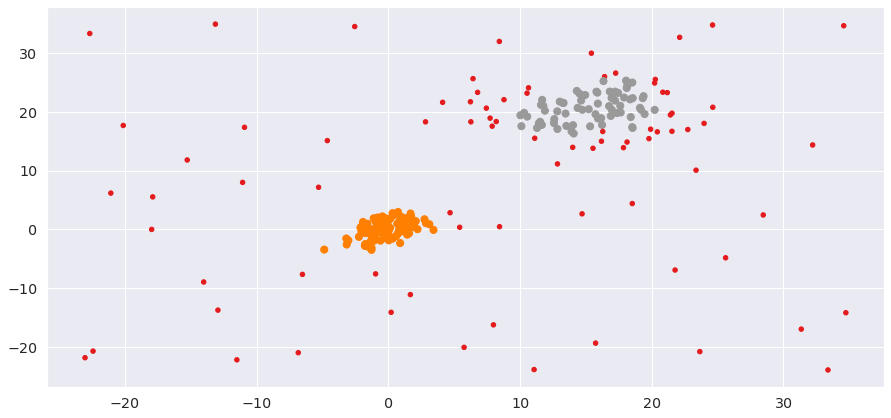

In [19]:
plt.figure(figsize=(15, 7))
plt.scatter(X[:, 0], X[:, 1], s=20 + 30 * (preds!=-1), c=preds, cmap='Set1');

### OneClassSVM

Метод работает для определения новизны, поэтому теперь создадим данные без выбросов

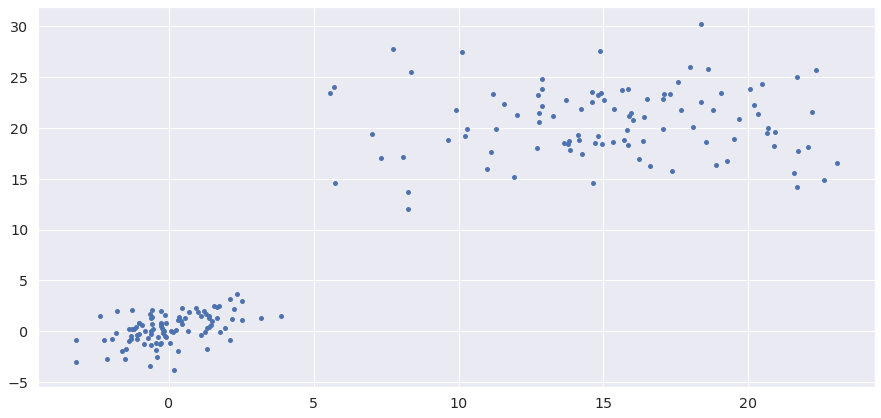

In [20]:
X1 = sps.multivariate_normal(cov=[[2, 1], [1, 2]]).rvs(size=100)
X2 = sps.multivariate_normal(mean=[15, 20], cov=[[15, 2], [2, 10]]).rvs(size=100)
X = np.vstack([X1, X2])

plt.figure(figsize=(15, 7))
plt.scatter(X[:, 0], X[:, 1], s=15);

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html">Страница на sklearn</a>

Параметры:
* `kernel` -- тип ядра. Метод обычно хорошо работает только с `rbf` (по умолчанию);
* `gamma` -- параметр ядра;
* `nu` -- верхняя граница доли выбросов в данных.

Поля:
* `support_` -- индексы опорных векторов;
* `support_vectors_` -- опорные вектора;
* `dual_coef_` -- коэффициенты опорных векторов;
* `intercept_` -- свободный коэффициент.

Обучаем модель.

In [21]:
svm = OneClassSVM()
svm.fit(X)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
            kernel='rbf', max_iter=-1, nu=0.5, random_state=None,
            shrinking=True, tol=0.001, verbose=False)

Степерью типичности точки служит метод `decision_function`, который вычисляет расстояние (со знаком) до разделяющей гиперплоскости (в спрямляющем пространстве). Отрицательные значения соответствовуют аномалиям.

In [22]:
svm.decision_function([[0,0],
                       [10, 10],
                       [-20, -20]])

array([ 2.19918960e-03, -3.06791392e+00, -3.09468614e+00])

Визуализация результата. Для построения графика создается двумерная сетка точек. Далее для каждой точки из сетки вычисляется значение решающей функции. Раскраска области создается при помощи функции `plt.contourf`.

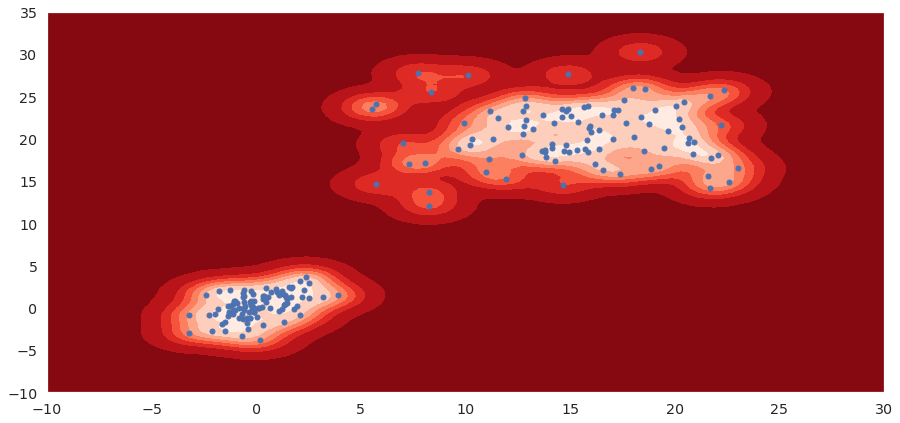

In [23]:
xx, yy = np.meshgrid(np.linspace(-10, 30, 100), np.linspace(-10, 35, 100))
Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15, 7))
plt.contourf(xx, yy, Z, cmap=plt.cm.Reds_r)
plt.scatter(X[:, 0], X[:, 1], s=25);

## Данные о свойствах вин

In [24]:
winequality = pd.read_csv("./winequality-red.csv", sep=';')
winequality.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


Посмотрим на боксплоты по всем признакам. Цель поиска выбросов -- найти наилучшие вина.

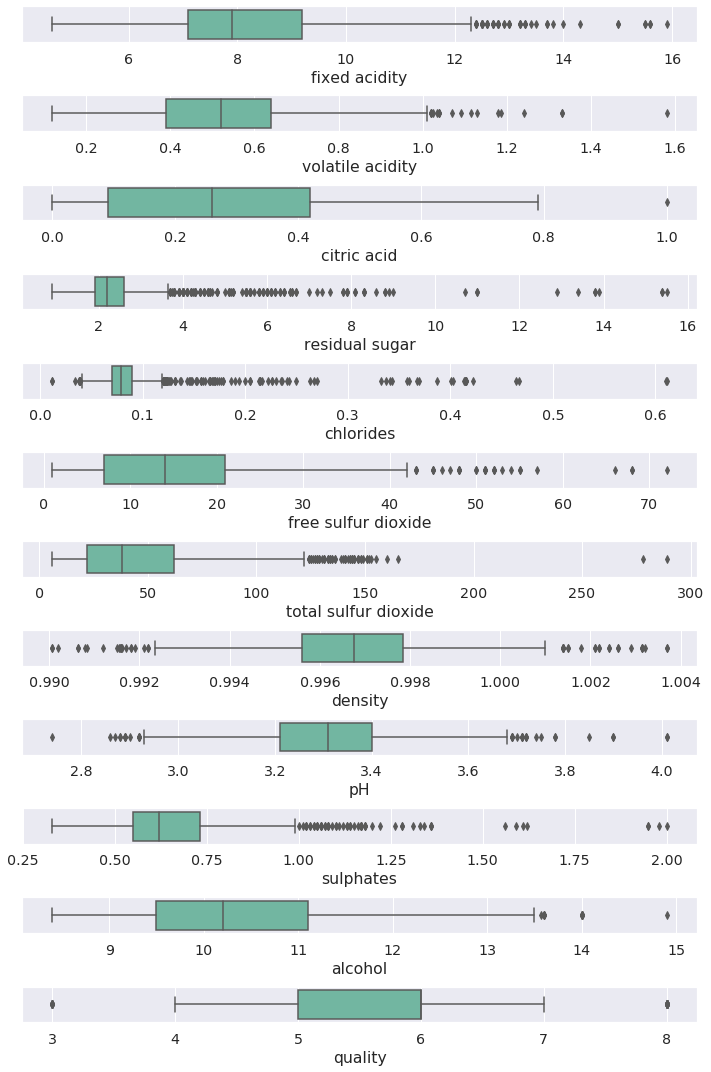

In [25]:
plt.figure(figsize=(10, 15))
for i, c in enumerate(winequality.columns):
    plt.subplot(winequality.shape[1], 1, i+1)
    sns.boxplot(x=winequality[c], palette='Set2')
plt.tight_layout()

Оставим только первые 5

In [26]:
winequality = winequality.iloc[:, :5]

Применим IsolationForest на 2.5% выбросов и 1000 деревьев и визуализируем результат.

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


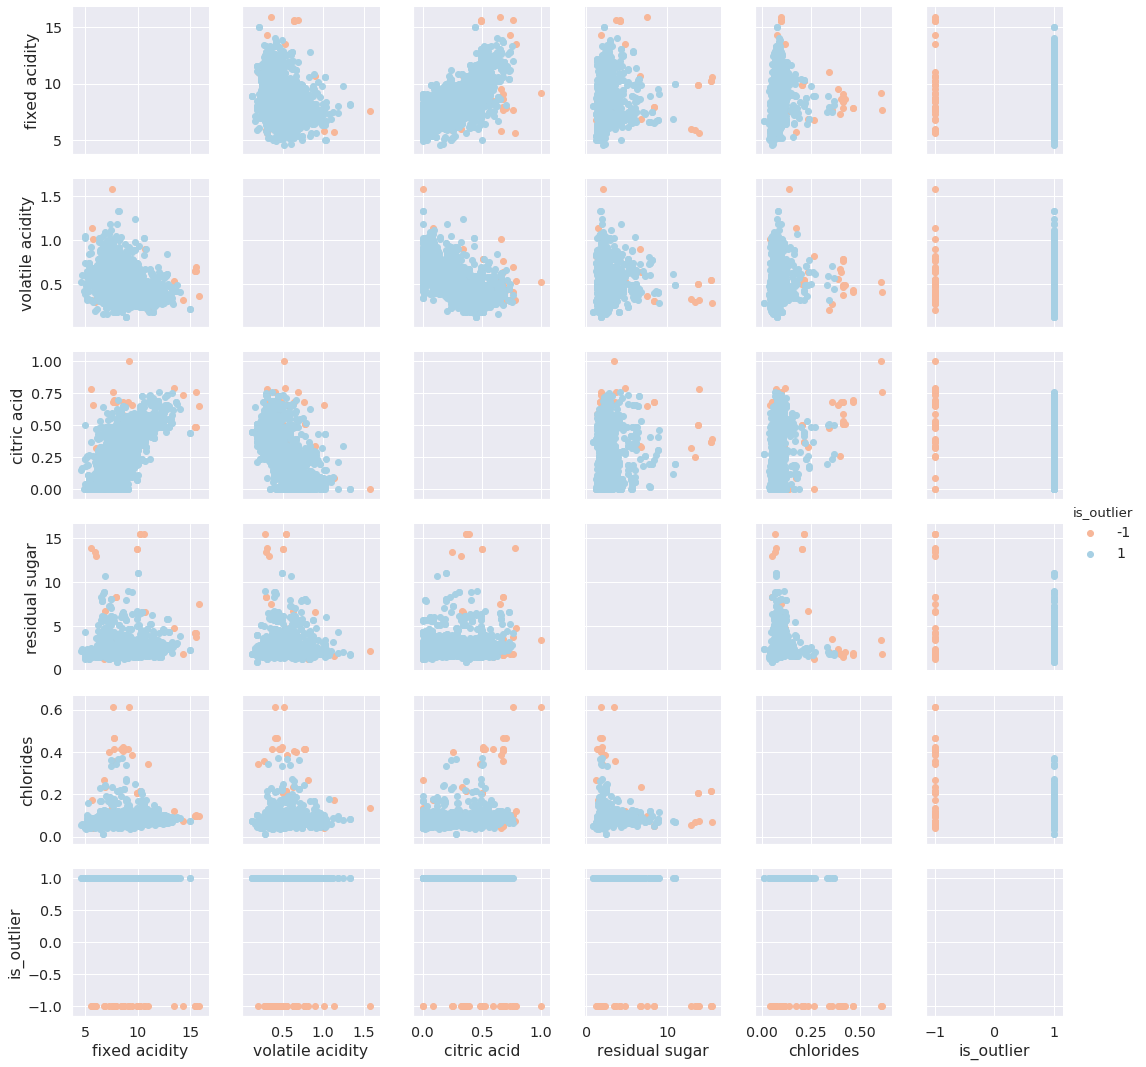

In [27]:
iforest = IsolationForest(contamination=0.025, n_estimators=1000)
is_outlier = iforest.fit_predict(winequality)

winequality_IF = winequality.copy()
winequality_IF['is_outlier'] = is_outlier

plot = sns.PairGrid(winequality_IF, hue='is_outlier', palette='RdBu')
plot = plot.map_offdiag(plt.scatter);
plot = plot.add_legend()

Количество выбросов, которые мы нашли

In [28]:
(is_outlier == -1).sum()

39

Применим LocalOutlierFactor на 2.5% и 10 соседей и визуализируем результат

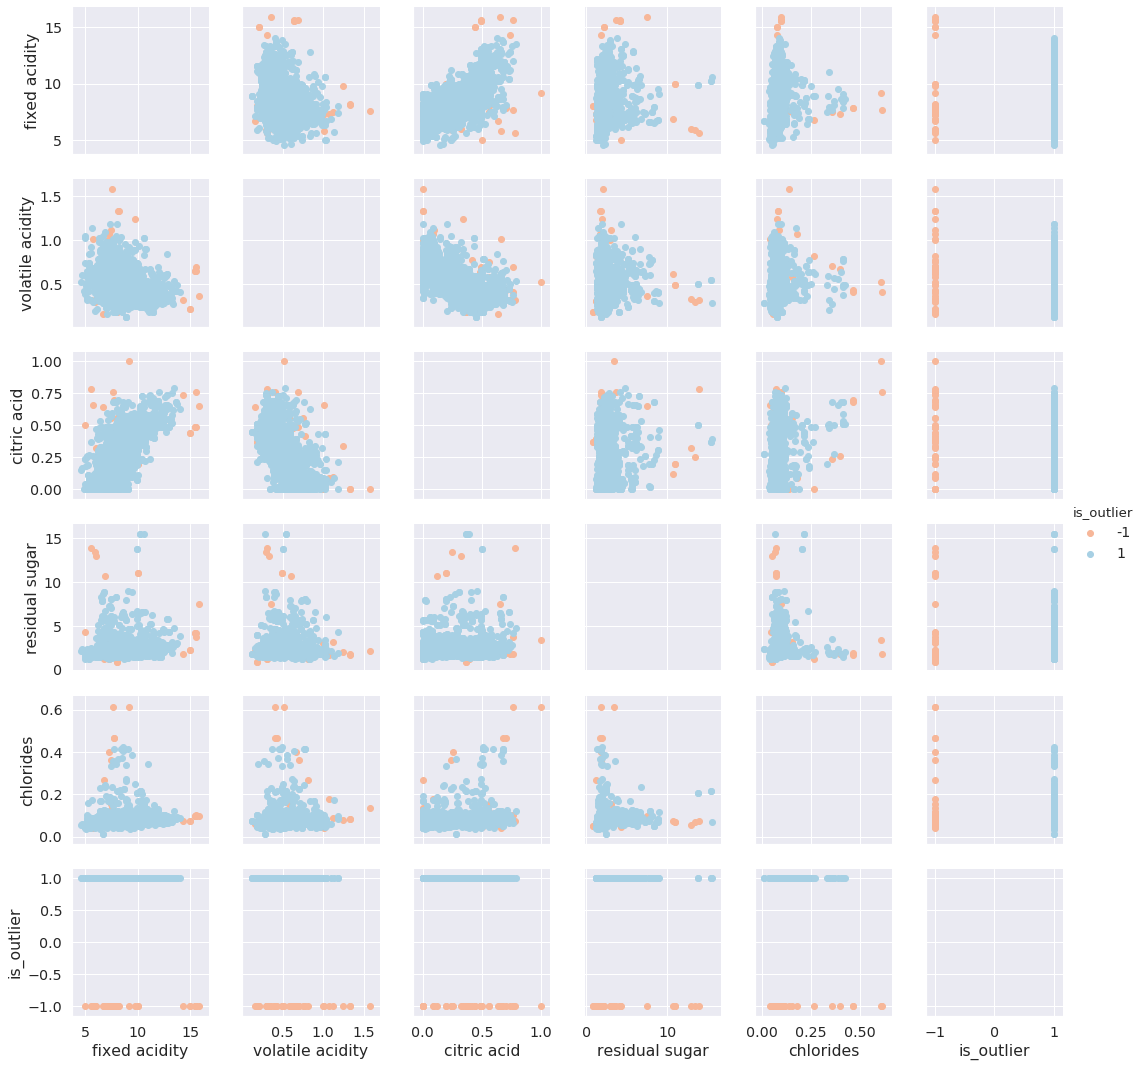

In [29]:
lof = LocalOutlierFactor(contamination=0.025, n_neighbors=10)
is_outlier = lof.fit_predict(winequality)

winequality_LOF = winequality.copy()
winequality_LOF['is_outlier'] = is_outlier

plot = sns.PairGrid(winequality_LOF, hue='is_outlier', palette='RdBu')
plot = plot.map_offdiag(plt.scatter);
plot = plot.add_legend()

Количество выбросов, которое мы нашли. Такое же, т.к. мы явно задали, сколько их :)

In [30]:
(is_outlier == -1).sum()

40